In [11]:
import copy,re,sys
from pdastro import pdastroclass,pdastrostatsclass,unique
import pandas as pd
from astropy.io import fits
import numpy as np

imnames=['nrc30/v1/jw01070001001_02101_00001_nrcalong_tweakregstep.fits',
        'nrc30/v1/jw01070001001_06101_00001_nrcalong_tweakregstep.fits',
        'nrc30/v1/jw01070001001_04101_00001_nrcalong_tweakregstep.fits'
        ]

photname=list(np.empty(len(imnames)))
phots = list(np.empty(len(imnames)))
copy_suffix = list(np.empty(len(imnames)))
for i in range(len(imnames)): 
    photname[i] = re.sub('\.fits$','.good.phot.txt',imnames[i])
    if photname[i] == imnames[i]: 
        raise RuntimeError(f'BUG!!! {photname[i]}')
    im = fits.open(imnames[i])
    aperture = im['PRIMARY'].header['APERNAME']
    pupil = re.sub('MASK','',im['PRIMARY'].header['PUPIL'])
    obsnum = im['PRIMARY'].header['OBSERVTN']
    phots[i]= pdastrostatsclass()
    phots[i].load(photname[i])
    if 'gaia_source_id' in phots[i].t.columns:
        phots[i].t['gaia_source_id']=phots[i].t['gaia_source_id'].astype(pd.Int64Dtype())
    copy_suffix[i] = f'{obsnum}_{pupil}'
    print(f'{photname[i]}: {aperture} {pupil} {obsnum} ({len(phots[i].t)} rows): {copy_suffix[i]}')
    

nrc30/v1/jw01070001001_02101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL CLEAR 001 (1330 rows): 001_CLEAR
nrc30/v1/jw01070001001_06101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_BAR BAR 001 (133 rows): 001_BAR
nrc30/v1/jw01070001001_04101_00001_nrcalong_tweakregstep.good.phot.txt: NRCA5_FULL_WEDGE_RND RND 001 (174 rows): 001_RND


In [12]:
phots[1].write()
# add all coordinate columns to each phot file: x/y_idl, v2/v3

 aper_sum_3.5px  annulus_median_3.5px  aper_bkg_3.5px  aper_sum_bkgsub_3.5px  flux_err_3.5px       mag     dmag           x           y  sharpness  roundness1  roundness2        ra        dec      x_idl      y_idl   gaia_ra   gaia_dec  gaia_ID      gaia_source_id  gaia_ra_error  gaia_dec_error    gaia_g  gaia_g_err   gaia_rp  gaia_rp_err  gaia_g_rp  gaia_g_rp_err   __weights  d_rot_tmp  __tmp_residuals  delta_mag      gaia_x      gaia_y        dx        dy
      66.701235              0.250960        9.768754              56.932481        3.144782 -4.388400 0.059987  898.455484    9.566212   0.668735    0.834011    0.609071 80.487979 -69.495802  -8.031302 -63.791752 80.487982 -69.495800   2172.0 4657988102353299712       0.080483        0.074005 17.815584    0.001374 17.029600     0.021669   0.785984       5.233331   56.932467   0.298703         0.048490 -22.203984  898.576249    9.554568  0.120765 -0.011644
     157.270770              0.463838       18.055164             139.215606  

0

In [18]:
def find_matches(phot0, phot1, suffix4copycol, ixs_phot0=None, ixs_phot1=None, refcat_prefix='gaia',
                cols2copy=['ra','dec','x_idl','y_idl']):
    Ndouble = 0
    idcol = f'{refcat_prefix}_source_id'
    ixs_phot0 = phot0.getindices(ixs_phot0)
    ixs_phot1 = phot1.getindices(ixs_phot1)
    ix0_singlematch=[]
    ix1_singlematch=[]
    for ix0 in ixs_phot0:
        ID = phot0.t.loc[ix0,idcol]
        ix1_match = phot1.ix_equal(idcol,ID,indices=ixs_phot1)
        #print(f'{ID}: {len(ixs_match)}')
        if len(ix1_match)==1:
            ix0_singlematch.append(ix0)
            ix1_singlematch.append(ix1_match[0])
    print(f'matches: {len(ix0_singlematch)}')
    for sourcecol in ['x','y','x_idl','y_idl','ra','dec']:
        destcol = f'{sourcecol}_{suffix4copycol}'
        phot0.t.loc[ix0_singlematch,destcol]=list(phot1.t.loc[ix1_singlematch,sourcecol])
    return(ix0_singlematch)

diff_mean = pdastrostatsclass()
diff_mean.t['diffname']=None
diff_mean.param2columnmapping = diff_mean.intializecols4statparams()

outcols= ['mag','dmag','x','y','ra','dec','x_idl','y_idl','gaia_ra','gaia_dec','gaia_source_id']
ixs0_keep = []
for i in range(1,len(imnames)):
    ixs0_match = find_matches(phots[0],phots[i],copy_suffix[i])
    for col0 in ['x','y','x_idl','y_idl']:
        # get column names
        coli = f'{col0}_{copy_suffix[i]}'
        dcol = f'diff_{col0}_{copy_suffix[i]}'
        #print(col0,coli,dcol)
        
        # calculate difference
        phots[0].t.loc[ixs0_match,dcol] =  phots[0].t.loc[ixs0_match,coli] - phots[0].t.loc[ixs0_match,col0] 
        
        # keep the columns for the output
        outcols.extend([coli,dcol])
        
        # do statistics!
        phots[0].calcaverage_sigmacutloop(dcol,verbose=3,indices=ixs0_match,percentile_cut_firstiteration=80)
        print(phots[0].statstring())

        ix_result = diff_mean.newrow({'diffname':dcol})
        diff_mean.statresults2table(phots[0].statparams,
                                    diff_mean.param2columnmapping,
                                    destindex=ix_result)
    ixs0_keep.extend(ixs0_match)
ixs0_keep = unique(ixs0_keep)
#sys.exit(0)
#ix0_match = find_matches(phots[0],phots[1],copy_suffix='001')
#print(phots[0].t.columns)
#phots[0].write(columns=outcols,indices=ixs0_keep)
outfilename = re.sub('\.txt$','.matches.txt',photname[0])
if outfilename == photname[0]: raise RuntimeError('BUGG!!!!!')
print(f'Saving matches to {outfilename}')
phots[0].write(outfilename,columns=outcols,indices=ixs0_keep)
outfilename = re.sub('\.txt$','.mean.txt',photname[0])
if outfilename == photname[0]: raise RuntimeError('BUGG!!!!!')
diff_mean.write(outfilename)
#phots[0].write(columns=['x','y','ra','dec','x_idl','y_idl','x_idl001_BAR','d_x_idl_x_idl001_BAR'])
#phots[0].write()
#print(phots[0].t['x_idl001'])

matches: 81
Keeping 81 out of 81, skippin 0 because of null values in columns diff_x_001_BAR
median: -36.146546
80.000000 percentile cut: max residual for cut: 0.909678
median: -36.090834
i:00 mean:-36.090834(0.052785) stdev:0.418969(0.037032) X2norm:0.99 Nchanged:0 Ngood:64 Nclip:17

mean: -36.146034
i:01 mean:-36.146034(0.059308) stdev:0.489064(0.041632) X2norm:1.00 Nchanged:5 Ngood:69 Nclip:12

mean: -36.180622
i:02 mean:-36.180622(0.069880) stdev:0.601131(0.049082) X2norm:1.00 Nchanged:6 Ngood:75 Nclip:6

mean: -36.258261
i:03 mean:-36.258261(0.080573) stdev:0.720671(0.056621) X2norm:1.00 Nchanged:6 Ngood:81 Nclip:0

mean: -36.258261
i:04 mean:-36.258261(0.080573) stdev:0.720671(0.056621) X2norm:1.00 Nchanged:0 Ngood:81 Nclip:0
i:04 mean:-36.258261(0.080573) stdev:0.720671(0.056621) X2norm:1.00 Nchanged:0 Ngood:81 Nclip:0
Keeping 81 out of 81, skippin 0 because of null values in columns diff_y_001_BAR
median: -747.277284
80.000000 percentile cut: max residual for cut: 0.761841
medi

0

<AxesSubplot:xlabel='y', ylabel='diff_y_idl_001_BAR'>

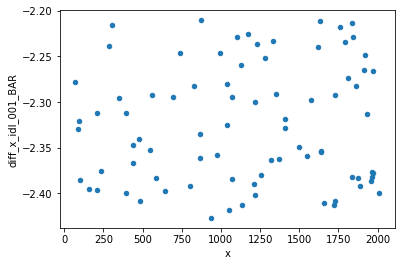

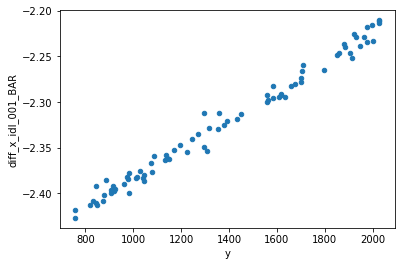

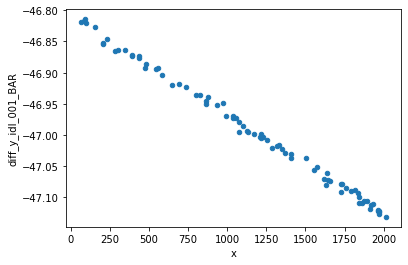

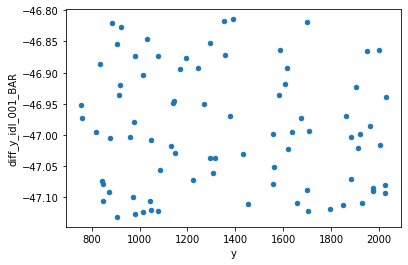

In [9]:
phots[0].t.plot.scatter('x','diff_x_idl_001_BAR')
phots[0].t.plot.scatter('y','diff_x_idl_001_BAR')
phots[0].t.plot.scatter('x','diff_y_idl_001_BAR')
phots[0].t.plot.scatter('y','diff_y_idl_001_BAR')